In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
%matplotlib inline

In [ ]:
# fwiw I had to re-save the .csv files in Sublime text with utf-8 encoding to open them

In [3]:
users = pd.read_csv('takehome_users-utf8.csv', encoding='utf8')
user_e = pd.read_csv('takehome_user_engagement-utf8.csv', encoding='utf8')

In [12]:
#-# users df
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [13]:
#-# user engagement table
user_e.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# make sure user_e is sorted by user_id, then time_stamp
user_e = user_e.sort_values(by=['user_id', 'time_stamp'])

In [15]:
user_e.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
#-# in order to identify which factors predict future user adoption, we will extract features from both dataframes
#-# once features have been extracted, we will utilize various classifiers to test the predictive value of each one
#-# once we have a classifier we are comfortable with, we will examine the features that that particular classifier...
#-# ...has determined have the most impact on future user adoption; the first part of this notebook details how to...
#-# ...to prepare the dataframes for analysis; the second part will show accuracy scores for different classifiers.

#-# remove timestamp from date - because an "adopted user" is considered to be a user who has logged into the product...
#-# on three separate days in at least one seven-day period, the times of login aren't relevant.
user_e['time_stamp'] = pd.to_datetime(user_e['time_stamp'])
user_e['date'] = pd.DatetimeIndex(user_e.time_stamp).normalize()
user_e = user_e.drop('time_stamp', 1)
user_e.head()

,user_id,visited,date
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25


In [21]:
# remove duplicate rows (actually I think there are none)
len(user_e)

207917

In [22]:
user_e = user_e.drop_duplicates()
len(user_e)

207917

In [6]:
# create four columns: user_id_above, user_id_below, date_above, date_below
# these will be used to determine who has logged into the product on three separate days in at least one seven day period

#-# the goal is to subtract the current row's date field from the "date above" field and the "date below" field
#-# if the difference between these values is within 7 days, and if all the ids are the same, this will indicate...
#-# ...that the row shows a user_id that is a adopted user, based on criteria defined above.

user_e['user_id_above'] = user_e.user_id.shift(1)
user_e['user_id_below'] = user_e.user_id.shift(-1)
user_e['date_above'] = user_e.date.shift(1)
user_e['date_below'] = user_e.date.shift(-1)
user_e.head()

,user_id,visited,date,user_id_above,user_id_below,date_above,date_below
0,1,1,2014-04-22,NaN,2.0,NaT,2013-11-15
1,2,1,2013-11-15,1.0,2.0,2014-04-22,2013-11-29
2,2,1,2013-11-29,2.0,2.0,2013-11-15,2013-12-09
3,2,1,2013-12-09,2.0,2.0,2013-11-29,2013-12-25
4,2,1,2013-12-25,2.0,2.0,2013-12-09,2013-12-31


In [24]:
user_e.tail()

#-# note from the head and tail that there are NaN and NaT values, but it won't matter as long as those rows...
#-# ...indicate that the user_id on the first and last row of the dataframe are NOT adopted users...
#-# ...this is because upon examination of this df, user_id = 1 and user_id = 12000 only logged in once.

,user_id,visited,date,user_id_above,user_id_below,date_above,date_below
207912,11996,1,2013-09-06,11995.0,11997.0,2013-10-22,2013-01-15
207913,11997,1,2013-01-15,11996.0,11998.0,2013-09-06,2014-04-27
207914,11998,1,2014-04-27,11997.0,11999.0,2013-01-15,2012-06-02
207915,11999,1,2012-06-02,11998.0,12000.0,2014-04-27,2014-01-26
207916,12000,1,2014-01-26,11999.0,NaN,2012-06-02,NaT


In [7]:
# create two more columns: date_above_diff and date_below_diff, to count the number of days from the current date

#-# the purpose of the date_above_diff is to subtract the current date from the prior date; date_below_diff is to subtract...
#-# ...the date below from the current date.  The combination of these values will show us if an adopted user exists.
#-# ...this makes more sense with an example, which is described further down the workbook

user_e['date_above_diff'] = pd.to_datetime(user_e['date']) - pd.to_datetime(user_e['date_above'])
user_e['date_below_diff'] = pd.to_datetime(user_e['date_below']) - pd.to_datetime(user_e['date'])
user_e.head(10)

,user_id,visited,date,user_id_above,user_id_below,date_above,date_below,date_above_diff,date_below_diff
0,1,1,2014-04-22,NaN,2.0,NaT,2013-11-15,NaT,-158 days
1,2,1,2013-11-15,1.0,2.0,2014-04-22,2013-11-29,-158 days,14 days
2,2,1,2013-11-29,2.0,2.0,2013-11-15,2013-12-09,14 days,10 days
3,2,1,2013-12-09,2.0,2.0,2013-11-29,2013-12-25,10 days,16 days
4,2,1,2013-12-25,2.0,2.0,2013-12-09,2013-12-31,16 days,6 days
5,2,1,2013-12-31,2.0,2.0,2013-12-25,2014-01-08,6 days,8 days
6,2,1,2014-01-08,2.0,2.0,2013-12-31,2014-02-03,8 days,26 days
7,2,1,2014-02-03,2.0,2.0,2014-01-08,2014-02-08,26 days,5 days
8,2,1,2014-02-08,2.0,2.0,2014-02-03,2014-02-09,5 days,1 days
9,2,1,2014-02-09,2.0,2.0,2014-02-08,2014-02-13,1 days,4 days


In [8]:
#-# change type of user_id so we can equate this to user_id_above and user_id_below, which are floats
user_e['user_id'] = user_e['user_id'].astype(float)

In [9]:
# using the above output, row with index 8 is when user_id 2 became "adopted" - the login before the current date and after...
# ...if the days were summed is < 8.  now we can create a adopted column

#-# (NOTE: corrected the two lines above to read index 8 instead of index 7, which was incorrect)

user_e['adopted'] = np.where((user_e.user_id == user_e.user_id_above) & (user_e.user_id == user_e.user_id_below) & 
                           ((user_e.date_above_diff + user_e.date_below_diff).dt.days < 7), 1, 0)

#-# further details on this example and the where statement above: in row with index 8, user_id = 2.0, which is the same...
#-# ...as the user_id in the row above and the row below the current row; this indicates both the above and below row...
#-# ...refer to dates when the same user logged in; next check is to determine the difference between the first login and...
#-# ...the THIRD login; if three logins occur in one seven day period, this is an adaopted user and a 1 will appear in...
#-# ...the "adopted" column; we see this in the row with index 8; row above, index 7, same user, login date of 2/3/2014...
#-# ...index 8 login date = 2/8/2014; row below, index 9, same user, login date = 2/9/2014; this yields True for the...
#-# ...three criteria in the above where statement:
#-# user_e.user_id == user_e.user_id_above ??? - True
#-# user_e.user_id == user_e.user_id_below ??? - True (all three rows refer to the same user)
#-# (user_e.date_above_diff + user_e.date_below_diff).dt.days < 7 ??? - True
#-# formula above checks to see if the difference in dates in the three rows is less than 7; equal to 7 would be too many days:
#-# 2/3, 2/4, 2/5, 2/6, 2/7, 2/8, 2/9; difference from any point back and forward would need to be 6, since one of the days...
#-# ...would be represented on the current row


In [75]:
user_e.head(10)

,user_id,visited,date,user_id_above,user_id_below,date_above,date_below,date_above_diff,date_below_diff,adopted
0,1.0,1,2014-04-22,NaN,2.0,NaT,2013-11-15,NaT,-158 days,0
1,2.0,1,2013-11-15,1.0,2.0,2014-04-22,2013-11-29,-158 days,14 days,0
2,2.0,1,2013-11-29,2.0,2.0,2013-11-15,2013-12-09,14 days,10 days,0
3,2.0,1,2013-12-09,2.0,2.0,2013-11-29,2013-12-25,10 days,16 days,0
4,2.0,1,2013-12-25,2.0,2.0,2013-12-09,2013-12-31,16 days,6 days,0
5,2.0,1,2013-12-31,2.0,2.0,2013-12-25,2014-01-08,6 days,8 days,0
6,2.0,1,2014-01-08,2.0,2.0,2013-12-31,2014-02-03,8 days,26 days,0
7,2.0,1,2014-02-03,2.0,2.0,2014-01-08,2014-02-08,26 days,5 days,0
8,2.0,1,2014-02-08,2.0,2.0,2014-02-03,2014-02-09,5 days,1 days,1
9,2.0,1,2014-02-09,2.0,2.0,2014-02-08,2014-02-13,1 days,4 days,1


In [10]:
# create a df with just user_id and adopted value

#-# we made a copy just in case something goes wrong and we have to reload the original dataframe
#-# we'll eventually merge this information into the user dataframe, and this will be the value we will try to predict...
#-# ...based on user information
user_a = user_e.copy()
user_a = user_a.drop(['visited', 'date', 'user_id_above', 'user_id_below', 'date_above', 'date_below', 
                      'date_above_diff', 'date_below_diff'], axis=1)

In [77]:
user_a.head(10)

,user_id,adopted
0,1.0,0
1,2.0,0
2,2.0,0
3,2.0,0
4,2.0,0
5,2.0,0
6,2.0,0
7,2.0,0
8,2.0,1
9,2.0,1


In [12]:
#-# grouping by the user id and then taking the max value of each user id will give us a 1 or 0 for adopted or not by user
user_a_max = user_a.groupby(['user_id'], sort=False)['adopted'].max()
user_a_max.head()

user_id
1.0    0
2.0    1
3.0    0
4.0    0
5.0    0
Name: adopted, dtype: int32

In [13]:
#-# as with the original engagement df, object_id will need to be converted to match user_id
#-# also, our groupby variable needs to be changed to a dataframe
users['object_id'] = users['object_id'].astype(float)
user_a_max = user_a_max.to_frame()
user_a_max = user_a_max.reset_index()

In [84]:
user_a_max.head()

,user_id,adopted
0,1.0,0
1,2.0,1
2,3.0,0
3,4.0,0
4,5.0,0


In [14]:
#-# here is where we merge the two dataframes, on object_id (which is the same as user_id)

user_a_max['object_id'] = user_a_max['user_id']
users_w_adopted = pd.merge(users, user_a_max, on='object_id', how='left')

In [100]:
users_w_adopted.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1.0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1.0
2,3.0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,0.0
3,4.0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,0.0
4,5.0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,0.0
5,6.0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,6.0,0.0
6,7.0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,7.0,0.0
7,8.0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,NaN
8,9.0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,NaN
9,10.0,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10.0,1.0


In [15]:
#-# NaN values exist for some object_ids that aren't in the engagement table - they didn't log in and are not adopted
users_w_adopted.adopted.fillna(0, inplace=True)
#-# double-check the length, should be 12,000 user ids which is what we started with
len(users_w_adopted)

12000

In [104]:
users_w_adopted.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1.0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
1,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,1.0
2,3.0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,0.0
3,4.0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,0.0
4,5.0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,0.0
5,6.0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,6.0,0.0
6,7.0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,7.0,0.0
7,8.0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,0.0
8,9.0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,0.0
9,10.0,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,10.0,1.0


In [16]:
#-# we don't need multiple columns with the user_id, so we'll just use (and refer to) the "object id" from now on
users_w_adopted = users_w_adopted.drop('user_id', 1)

In [107]:
users_w_adopted.head(10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1.0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3.0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4.0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5.0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0
5,6.0,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0.0
6,7.0,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0.0
7,8.0,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0.0
8,9.0,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0.0
9,10.0,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0


In [17]:
#-# details on feature extraction below:

# make a copy and try extracting potential features
# from creation time: check month, year, day of week and hour
# from email, extract email domain and make numeric
# from creation source, change to number
# change invited by user_id from an actual id to binary

In [100]:
users_w_adopted_copy = users_w_adopted.copy()

In [62]:
#-# time and date extraction
users_w_adopted_copy['creation_time'] = pd.to_datetime(users_w_adopted_copy['creation_time'])
users_w_adopted_copy['creation_month'] = users_w_adopted_copy['creation_time'].dt.month
users_w_adopted_copy['creation_year'] = users_w_adopted_copy['creation_time'].dt.year
users_w_adopted_copy['creation_dayofweek'] = users_w_adopted_copy['creation_time'].dt.dayofweek
users_w_adopted_copy['creation_hour'] = users_w_adopted_copy['creation_time'].dt.hour

In [36]:
# check to see if creation time elements seem to have any correlation at all
users_w_adopted_copy.corr()['adopted']

object_id                     0.005750
last_session_creation_time    0.396550
opted_in_to_mailing_list      0.008097
enabled_for_marketing_drip    0.004653
org_id                        0.064523
invited_by_user_id            0.000675
adopted                       1.000000
creation_month                0.040087
creation_year                -0.087539
creation_dayofweek            0.003084
creation_hour                 0.000104
Name: adopted, dtype: float64

In [63]:
#-# based on correlation, it doesn't seem to matter when a user created their id in terms of what day of the week...
#-# ...it was or what hour of the day; we'll drop this, along with the original creation time field
# drop columns that will not be used
users_w_adopted_copy = users_w_adopted_copy.drop(['creation_time', 'creation_dayofweek', 'creation_hour'], axis=1)

In [102]:
#-# here we're checking to see if it matters what email domain is associated with each object id
f = lambda x: x['email'].split('@')[1]
users_w_adopted_copy['email_domain'] = users_w_adopted_copy.apply(f, axis=1)

In [52]:
users_w_adopted_copy.head()

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_month,creation_year,email_domain
0,1.0,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,4,2014,yahoo.com
1,2.0,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,11,2013,gustr.com
2,3.0,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,3,2013,gustr.com
3,4.0,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,5,2013,yahoo.com
4,5.0,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,1,2013,yahoo.com


In [103]:
#-# what email groups are there?  thought there might be a different distribution of these, but this will be easy to group...
#-# we'll take the top 6, group those, and throw everything else into an "other" category
users_w_adopted_copy.groupby(['email_domain']).size().sort_values(ascending=False)[0:10]

email_domain
gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
qgjbc.com            2
xybhi.com            2
oqpze.com            2
luque.com            2
dtype: int64

In [65]:
# create 7 categories for email domain
users_w_adopted_copy.email_domain = np.where(users_w_adopted_copy.email_domain == 'gmail.com', 1, 
                                    np.where(users_w_adopted_copy.email_domain == 'yahoo.com', 2,
                                    np.where(users_w_adopted_copy.email_domain == 'jourrapide.com', 3,
                                    np.where(users_w_adopted_copy.email_domain == 'cuvox.de', 4,
                                    np.where(users_w_adopted_copy.email_domain == 'gustr.com', 5,
                                    np.where(users_w_adopted_copy.email_domain == 'hotmail.com', 6, 0))))))

In [66]:
#-# here we convert creation source; based on the original documentation it is stated that there are only 5 possible values
users_w_adopted_copy.creation_source = np.where(users_w_adopted_copy.creation_source == 'PERSONAL_PROJECTS', 1, 
                                       np.where(users_w_adopted_copy.creation_source == 'GUEST_INVITE', 2,
                                       np.where(users_w_adopted_copy.creation_source == 'ORG_INVITE', 3,
                                       np.where(users_w_adopted_copy.creation_source == 'SIGNUP', 4,
                                       np.where(users_w_adopted_copy.creation_source == 'SIGNUP_GOOGLE_AUTH', 5, 0)))))

In [69]:
#-# here we're going to change 'invited by user id' to a binary of 1 for yes, 0 for no - we don't care who invited them...
#-# ...just whether or not they were invited
users_w_adopted_copy.invited_by_user_id = users_w_adopted_copy.invited_by_user_id.fillna(0)
users_w_adopted_copy.invited_by_user_id = np.where(users_w_adopted_copy.invited_by_user_id > 0, 1, 0)

In [70]:
users_w_adopted_copy.head(10)

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_month,creation_year,email_domain
0,1.0,Clausen August,AugustCClausen@yahoo.com,2,1.398139e+09,1,0,11,1,0.0,4,2014,2
1,2.0,Poole Matthew,MatthewPoole@gustr.com,3,1.396238e+09,0,0,1,1,1.0,11,2013,5
2,3.0,Bottrill Mitchell,MitchellBottrill@gustr.com,3,1.363735e+09,0,0,94,1,0.0,3,2013,5
3,4.0,Clausen Nicklas,NicklasSClausen@yahoo.com,2,1.369210e+09,0,0,1,1,0.0,5,2013,2
4,5.0,Raw Grace,GraceRaw@yahoo.com,2,1.358850e+09,0,0,193,1,0.0,1,2013,2
5,6.0,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,2,1.387424e+09,0,0,197,1,0.0,12,2013,2
6,7.0,Sewell Tyler,TylerSewell@jourrapide.com,4,1.356010e+09,0,1,37,0,0.0,12,2012,3
7,8.0,Hamilton Danielle,DanielleHamilton@yahoo.com,1,NaN,1,1,74,0,0.0,7,2013,2
8,9.0,Amsel Paul,PaulAmsel@hotmail.com,1,NaN,0,0,302,0,0.0,11,2013,6
9,10.0,Santos Carla,CarlaFerreiraSantos@gustr.com,3,1.401833e+09,1,1,318,1,1.0,1,2013,5


In [71]:
# drop columns not used in analysis
#-# name is not needed, we extracted the value we wanted from email, and last session time will not be used because we wouldn't...
#-# ...have this for a new user prior to initial login
users_w_adopted_copy = users_w_adopted_copy.drop(['name', 'email', 'last_session_creation_time'], axis=1)

In [72]:
#-# rechecking the correlation values, there are a few that probably won't matter but it's only 8 so we'll use them all
users_w_adopted_copy.corr()['adopted']

object_id                     0.005750
creation_source               0.054553
opted_in_to_mailing_list      0.008097
enabled_for_marketing_drip    0.004653
org_id                        0.064523
invited_by_user_id            0.027671
adopted                       1.000000
creation_month                0.040087
creation_year                -0.087539
email_domain                  0.001048
Name: adopted, dtype: float64

In [73]:
# create columns list for only the columns that will be used to predict target value
columns = users_w_adopted_copy.columns.tolist()
columns = [c for c in columns if c not in ['object_id', 'adopted']]
target = 'adopted'

In [75]:
#-# create train and test sets and then we will utilize our various classifiers to find which one most accurately predicts...
#-# ...adoption
train, test = train_test_split(users_w_adopted_copy, test_size=0.2)

In [86]:
# experimentation with different classification models, looking for highest accuracy score
clfxgb = xgb.XGBClassifier().fit(train[columns], train[target])
predictionsxgb = clfxgb.predict(test[columns])
accuracy_score(test[target], predictionsxgb)

0.86916666666666664

In [87]:
clfmlp = MLPClassifier().fit(train[columns], train[target])
predictionsmlp = clfmlp.predict(test[columns])
accuracy_score(test[target], predictionsmlp)

0.86833333333333329

In [88]:
clfkn = KNeighborsClassifier().fit(train[columns], train[target])
predictionskn = clfkn.predict(test[columns])
accuracy_score(test[target], predictionskn)

0.85124999999999995

In [89]:
clfsv = SVC().fit(train[columns], train[target])
predictionssv = clfsv.predict(test[columns])
accuracy_score(test[target], predictionssv)

0.86708333333333332

In [91]:
clfdt = DecisionTreeClassifier(max_depth=5).fit(train[columns], train[target])
predictionsdt = clfdt.predict(test[columns])
accuracy_score(test[target], predictionsdt)

0.86458333333333337

In [92]:
clfrf = RandomForestClassifier().fit(train[columns], train[target])
predictionsrf = clfrf.predict(test[columns])
accuracy_score(test[target], predictionsrf)

0.82833333333333337

In [93]:
clfab = AdaBoostClassifier().fit(train[columns], train[target])
predictionsab = clfab.predict(test[columns])
accuracy_score(test[target], predictionsab)

0.86916666666666664

In [94]:
clfgnb = GaussianNB().fit(train[columns], train[target])
predictionsgnb = clfgnb.predict(test[columns])
accuracy_score(test[target], predictionsgnb)

0.86916666666666664

In [95]:
clfqda = QuadraticDiscriminantAnalysis().fit(train[columns], train[target])
predictionsqda = clfqda.predict(test[columns])
accuracy_score(test[target], predictionsqda)

0.86916666666666664

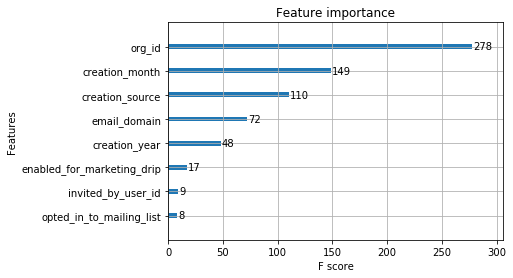

In [96]:
# several classifiers had equal accuracy scores, will use xgboost to show importance of different columns
plot_importance(clfxgb)
plt.show()

In [97]:
# org_id is the organization (group of users) they belong to - however there are many of these, might be useful to try...
# ...grouping them to look for correlations within the groups of org_ids
users_w_adopted_copy.groupby(['org_id'])['adopted'].mean().sort_values(ascending=False)

org_id
387    0.583333
235    0.461538
270    0.428571
399    0.384615
415    0.375000
400    0.375000
392    0.375000
117    0.363636
345    0.357143
318    0.352941
291    0.352941
289    0.352941
395    0.333333
161    0.333333
82     0.333333
381    0.333333
281    0.333333
306    0.333333
218    0.333333
177    0.315789
305    0.307692
62     0.307692
343    0.300000
352    0.300000
282    0.294118
273    0.294118
366    0.294118
225    0.294118
238    0.294118
280    0.294118
         ...   
351    0.050000
327    0.050000
125    0.045455
349    0.045455
143    0.043478
229    0.043478
406    0.043478
101    0.041667
204    0.040000
26     0.037736
0      0.034483
86     0.028571
51     0.026316
329    0.000000
412    0.000000
396    0.000000
394    0.000000
365    0.000000
362    0.000000
355    0.000000
346    0.000000
310    0.000000
307    0.000000
299    0.000000
279    0.000000
242    0.000000
237    0.000000
183    0.000000
151    0.000000
416    0.000000
Name: adopted, Le

In [ ]:
#-# so, our final answer to the question "which factors predict future user adoption" - org_id seems to be a significant...
#-# ...factor, and that is the organization (group of users) that the given id belongs to; also worth checking into would be...
#-# ...creation month (maybe some seasonality going on) and creation_source (how the account was created).